# Traffic Sign Classifier using Tensorflow

For this notebook we will train and validate a model so it can classify traffic sign images using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). After the model is trained, we will then try out the model on images of German traffic signs found on the web.

[Here](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) is a published baseline model and inspiration for solving the traffic sign problem.

**NOTE:** To try your own dataset feel free to change input directory in the 'Load The Data' section.

---

## Import Modules

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.contrib.layers import flatten
import tensorflow as tf
from sklearn.utils import shuffle
import pandas as pd
%matplotlib inline

## Load The Data
The dataset obtained has been resized to 32x32 and stored as pickle files. These dataset files has been placed in a folder called `data`.
Each pickle file contains a dictionary with 4 key/value pairs:

- **features** is a 4D array containing raw pixel data of the traffic sign images, (sample number, width, height, channels).
- **labels** is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- **sizes** is a list containing tuples, (width, height) representing the original width and height of the image.
- **coords** is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


In [2]:
# Fill this in based on where you saved the training, validation, and testing data
training_file = "../data/train.p"
validation_file="../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Visualize and Explore Dataset

#### General Info
There are multiple classes labeled as an id number in this dataset. The file `signnames.csv` contains id to name mappings for each id.


In [3]:
n_train = len(y_train)              # Number of training examples
n_validation = len(y_valid)         # Number of validation examples
n_test = len(y_test)                # Number of testing examples.
n_classes = len(np.unique(y_train)) # Number of classes in data set

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print()
print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set:   {} samples".format(n_train))
print("Validation Set: {} samples".format(n_validation))
print("Test Set:       {} samples".format(n_test))
print()
print("Number of classes = ", n_classes)
print("The class labels are: \n", np.unique(y_train))


Image Shape: (32, 32, 3)

Training Set:   34799 samples
Validation Set: 4410 samples
Test Set:       12630 samples

Number of classes =  43
The class labels are: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]


#### Dataset Labels

9960
2220
31439
5370
6810
12360
21450
23730
15870
11040
17130
8580
27329
21810
29219
29909
5010
30449
20370
6630
25950
25680
4500
1770
10800
33449
1230
10350
26849
10560
25020
210
10140
26250
20010
18930
900
4830
14010
25410
4200
0
9750


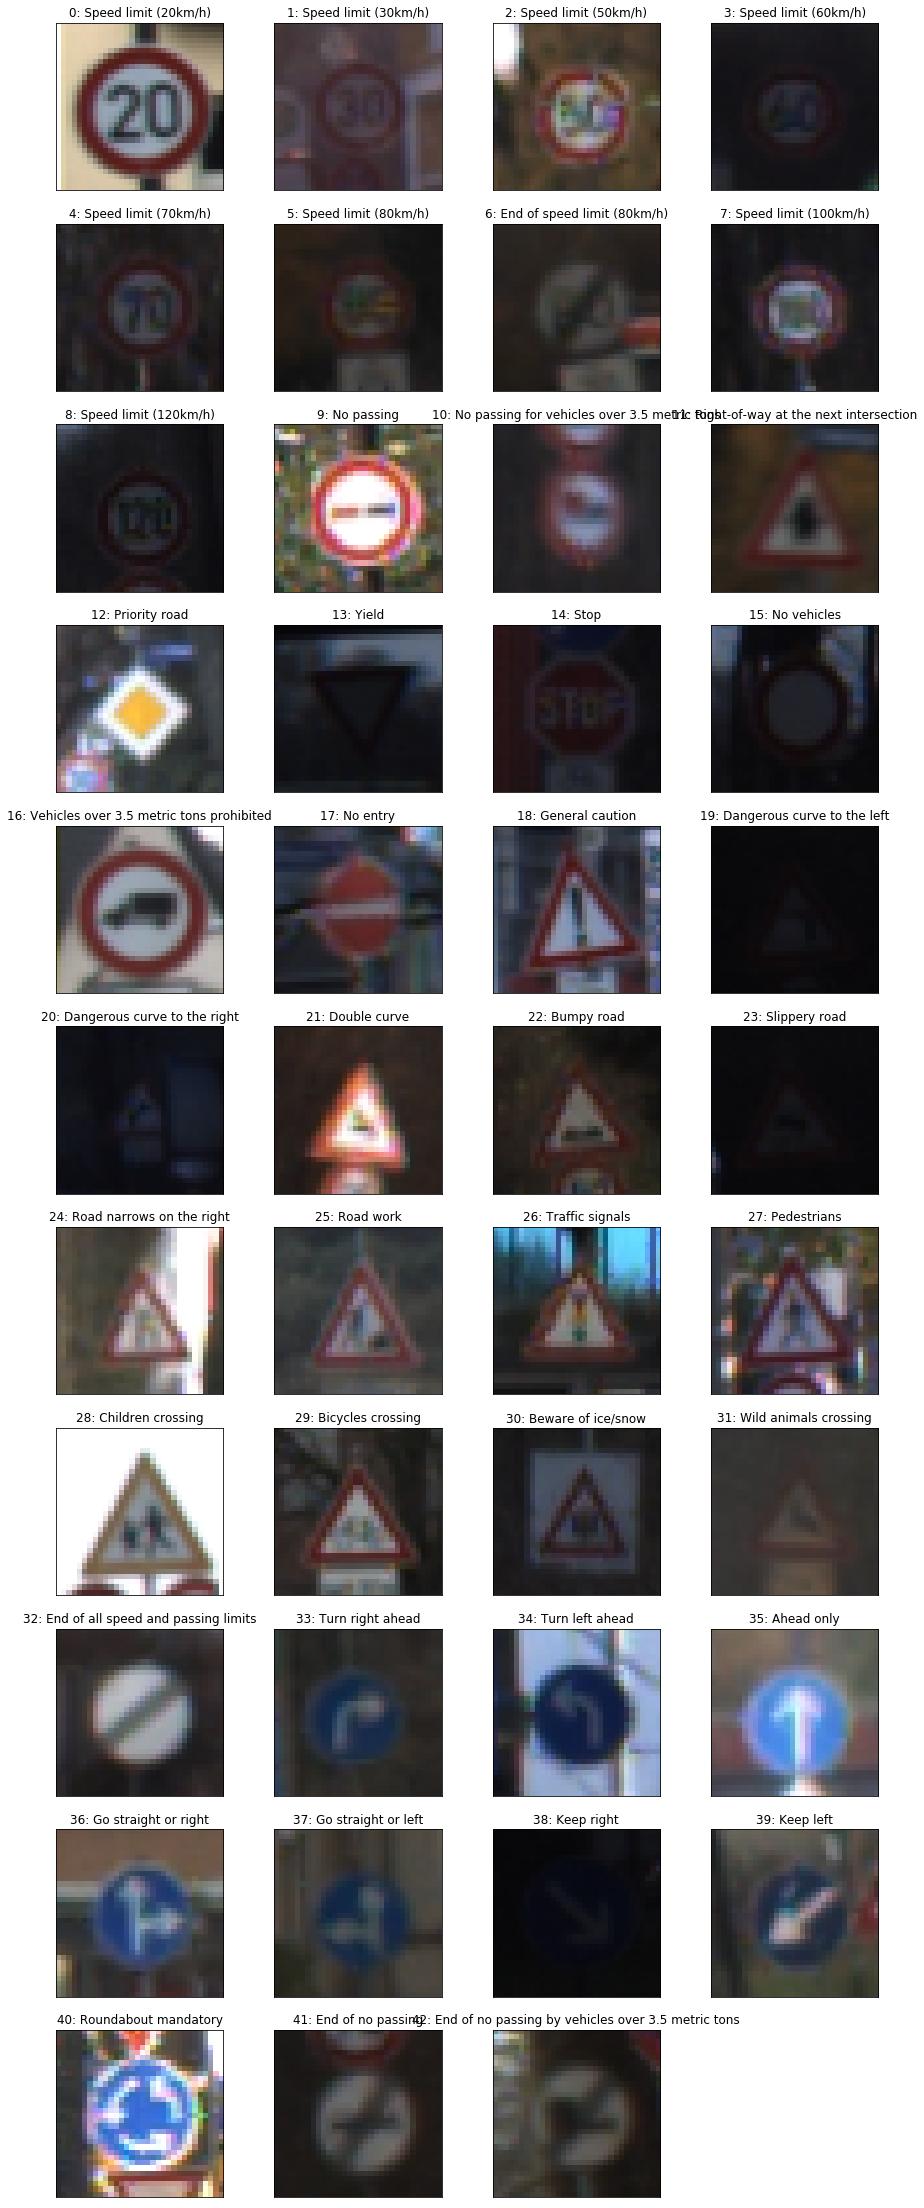

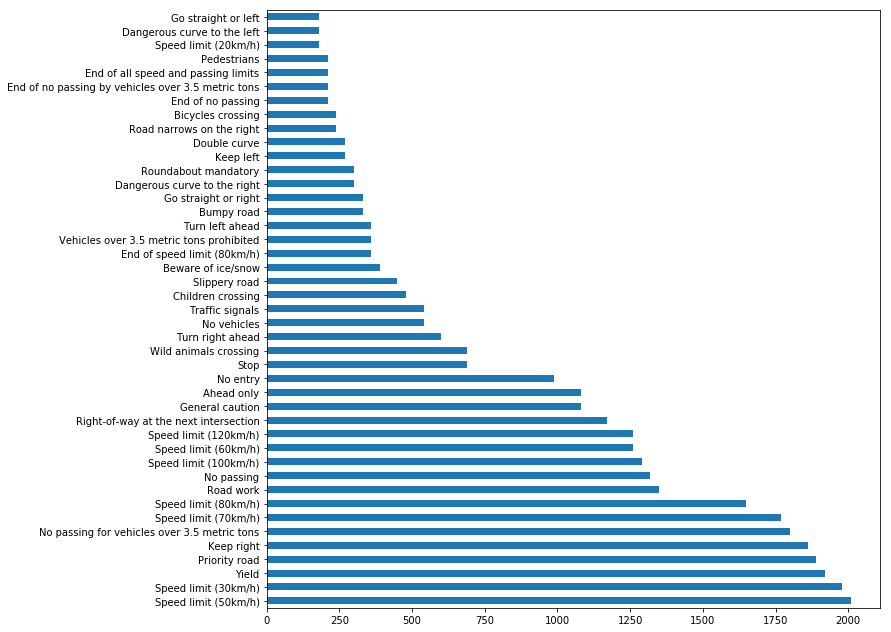

In [4]:
# Label Names
df = pd.read_csv('signnames.csv', sep=',')
label_names = np.array(df['SignName']) 

# Create Catalog
plt.figure(1,figsize=(15, 40))        #inches width and height
for i in range(n_classes):    
    plt.subplot(11,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(i) + ": " + str(label_names[i]))
    idx = np.nonzero([y_train == i])[1][0] # second element contains array of indeces, then Choose first element from selected indeces
    plt.imshow(X_train[idx])

# Create distribution
plt.figure(2,figsize=(12, 12))
df = pd.DataFrame(label_names[y_train], columns=['train_labels'])
df_train_labels = df['train_labels']
df_train_labels.value_counts().plot(kind='barh', figsize=(11, 11))

It can be interesting to look at the distribution of classes in the training set. The distribution is not the same; there are more examples of some classes than others. This raises the question: do we need to generate fake data to make the distribution even?

---
## Pre-process the Dataset

In [5]:
def preprocess(X, using_type=2):
    """ 
    Preprocess assumes X is of shape [numOfImages, height, width, channels]. 
    Set type number to specify the type of preprocessing you desire:
        Type 1: Quick way to approximately normalize the data (pixel - 128)/ 128.
        Type 2: Classical normalization.
        Type 3: ...
    """
    if (using_type == 1):
        return (X - 128)/ 128
    elif (using_type == 2):
        return (X - np.mean(X))/ np.std(X)
    
Xs_train = preprocess(X_train)
Xs_valid = preprocess(X_valid)
Xs_test = preprocess(X_test)


---
## Model Architecture

#### Network Parameters

In [6]:
EPOCHS = 10
BATCH_SIZE = 128
dropout = 0.75  # Dropout, probability to keep units in fully connected layers
learning_rate = 0.001

#### Weights and Biases for Net

In [7]:
# Define layers weight & bias
# wc: convolutional weights  -> [height, width, input_depth, output_depth]
# wd: dropout fc weights     -> [input_depth, output_depth]
# bc, bd: conv and fc biases -> [output_depth]

# Arguments used for tf.truncated_normal
mu = 0
sigma = 0.1

weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 3, 6], mean=mu, stddev=sigma)),
    'wc2': tf.Variable(tf.random_normal([5, 5, 6, 16], mean=mu, stddev=sigma)),
    'wd1': tf.Variable(tf.random_normal([5*5*16, 120], mean=mu, stddev=sigma)),
    'wd2': tf.Variable(tf.random_normal([120, 84], mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.random_normal([84, n_classes], mean=mu, stddev=sigma))}

biases = {
    'bc1': tf.Variable(tf.random_normal([6], mean=mu, stddev=sigma)),
    'bc2': tf.Variable(tf.random_normal([16], mean=mu, stddev=sigma)),
    'bd1': tf.Variable(tf.random_normal([120], mean=mu, stddev=sigma)),
    'bd2': tf.Variable(tf.random_normal([84], mean=mu, stddev=sigma)),
    'out': tf.Variable(tf.random_normal([n_classes], mean=mu, stddev=sigma))}

#### Helper functions for Net

In [8]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1], # [batch, height, width, depth]
        padding='SAME')
    

#### Net Classifier

In [9]:
keep = 0.75
def LeNet(x, weights, biases, keep):    
    
    # Layer 1: Convolutional-> Input = 32x32x3. Output = 28x28x6. Activation. Pooling-> Input = 28x28x6. Output = 14x14x6.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    conv1 = maxpool2d(conv1, k=2)
    #print(conv1.get_shape())
    
    # Layer 2: Convolutional-> Output = 10x10x16. Activation. Pooling-> Input = 10x10x16. Output = 5x5x16.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    conv2 = maxpool2d(conv2, k=2)
    #print(conv2.get_shape())

    # Layer 3: Flatten-> Input = 5x5x16 = Output = 400. Fully Connected-> Input = 400. Output = 120. Activation.
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84. Activation.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep)
    
    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    
    return out

## Pipeline

#### Placeholders
`x` is a placeholder for a batch of input images: features.

`y` is a placeholder for a batch of output labels.

`keep_prob` is a placeholder for specifying the probability of nodes to keep when performing dropout in fully connected layers.

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

#### Training

In [11]:
logits = LeNet(x, weights, biases,  keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)


#### Model Evaluation: Training, Validation, and Testing
Evaluate how well the loss and accuracy of the model for a given dataset per batch size. Set `keep_prob`to 1 to use all fc nodes during evaluation.

**Recall:** A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
# Note: the 1 in argmax means to search in two dimensions 
correct_prediction = tf.equal(tf.argmax(logits, 1) , tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#LOSS and ACCURACY
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        accuracy = sess.run(accuracy_operation, feed_dict={
            x: batch_x,
            y: batch_y,
            keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        
        loss = sess.run(loss_operation, feed_dict={
            x: batch_x,
            y: batch_y,
            keep_prob: 1.0})
     
    acc_per_epoch = total_accuracy / num_examples
    loss_of_last_batch = loss 
    return (acc_per_epoch, loss_of_last_batch)

---
## Run Session: Train the Model
- Run the training data through the training pipeline to train the model.

- Before each epoch, shuffle the training set.

- After each epoch, measure the loss and accuracy of the validation set.

- Save the model after training.

In [13]:
# Set up to save Model's weights
saver = tf.train.Saver()
save_file_path = './net_weights/lenet.ckpt'
#save_file_path = './lenet'

In [ ]:
# Train and Evaluate
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        
        Xs_train, y_train = shuffle(Xs_train, y_train)
        for offset in range(0, n_train, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = Xs_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: dropout})
        
        validation_accuracy, validation_loss = evaluate(Xs_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print("Validation Loss = {:.3f}".format(validation_loss))
        print()
        
    saver.save(sess, save_file_path)
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.729
Validation Loss = 0.976

EPOCH 2 ...
Validation Accuracy = 0.872
Validation Loss = 0.285



---

## Test a Model on New Images

Use your trained model to predict the traffic sign type on new images.

You may find `signnames.csv` useful for labeling the image as it contains mappings from the class id (integer) to the actual sign name.

#### Choose & Visualize Test Images

In [ ]:
# Load 5 images from the test set and plot them here.
idx = random.sample(range(len(X_test)), 5)

plt.figure(figsize=(10, 2))        #inches width and height
for i in range(len(idx)):    
    plt.subplot(1,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title("ID: " + str(y_test[idx[i]]))
    plt.imshow(X_test[idx[i]])

#### Predict the Sign Type for Each Test Image

In [ ]:
# Remove the previous weights and biases
#tf.reset_default_graph()

# Restore saved weights and test new images to obtain prediction y_hat
# saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./net_weights'))
    #saver.restore(sess, save_file_path)
    
    test_y_hat = sess.run(tf.argmax(logits, 1), feed_dict={
                        x: Xs_test[idx],
                        y: y_test[idx],
                        keep_prob: 1.0})
        
    print('Test Predicted Outputs: {}'.format(test_y_hat))


#### Analyze Accuracy Performance

In [ ]:
# Calculate the accuracy for these 5 new images. 
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./net_weights'))
    
    test_accuracy = sess.run(accuracy_operation, feed_dict={
                        x: Xs_test[idx],
                        y: y_test[idx],
                        keep_prob: 1.0})
    
    print('Test Accuracy: {} %'.format(test_accuracy*100))

#### Output Top 5 Softmax Probabilities For Each Test Image

We will make use of [`tf.nn.top_k`](https://www.tensorflow.org/api_docs/python/tf/math/top_k) 
to print out the model's top 5 softmax probabilities for each test image. 

In general, `tf.nn.top_k` returns the top_k values per row. Therefore, it returns a matrix where every row represents an image and there are top_k columns. It also returns another matrix of similar dimensions with the indeces of those top_k values. 

In [ ]:
# Print out the top five softmax probabilities for each test prediction.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('./net_weights'))
    
    test_all_softmax_prob = tf.nn.softmax(logits)
    test_top5_softmax_prob_operation = tf.nn.top_k(test_all_softmax_prob, k=5)
    
    test_top5_softmax_prob = sess.run(test_top5_softmax_prob_operation, feed_dict={
                                x: Xs_test[idx],
                                y: y_test[idx],
                                keep_prob: 1.0})
    
    # Display results
    for i in range(test_top5_softmax_prob[0].shape[0]):      # for every image
        print('For image X_test[{}] -> "{}" The top 5 softmax results:'.format(str(idx[i]) , label_names[y_test[idx[i]]] ) )
        for j in range(test_top5_softmax_prob[0].shape[1]):  # for each top value
            print('\t {} : {}% '.format(label_names[test_top5_softmax_prob[1][i][j]], round(test_top5_softmax_prob[0][i][j]*100,2)))
        print()    

---

## Visualize the Neural Network's State with Test Images

See the outputs of a test stimuli image at each layer of the network by plotting its feature maps. 

For example to see layer 2 of our neural network you could enter conv2 as the tf_activation variable. This helps us undestand the network's inner weights and understand if it has high activation to the sign's boundary outline or to the contrast in the sign's painted symbol, etc.

In [ ]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    """"
    Visualize your network's internal feature maps

    image_input       : the test image being fed into the network to produce the feature maps
    tf_activation     : should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer.
    activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
    plt_num           : used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

    """   
    # Preprocess your image_input
    image_input = preprocess(image_input)
    
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    
    #Total number of feature maps per layer
    featuremaps = activation.shape[3]
    
    #Plot layer´s feature maps
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [ ]:
plt.figure(figsize=(1, 1))             # one inch width and height
idx = random.randint(0, len(Xs_test)-1)# set is inclusive therefore -1
plt.imshow(Xs_test[idx])

print("Sample image in dataset with label: " , y_test[idx])

In [ ]:
image_input = 
tf_activation =
outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):